In [2]:
import time
import importlib
import sys
import pickle
import pandas as pd
import matplotlib.cm as cm
import pandas as pd
from scipy.stats import norm
from scipy import stats
import torch 
import matplotlib.colors as mcolors

import matplotlib as mpl
from matplotlib.ticker import MaxNLocator

vcol =['blue','red','orange','rosybrown','blueviolet','lawngreen','fuchsia','cyan','darkolivegreen','black','deepskyblue','lightslategray','darkslateblue','sienna','darkgoldenrod','olive']
list_color=['b','g','r','c','m','y']


import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 34})
import sys
import scipy
import os
PATH = '../codes/'
sys.path.insert(1,PATH)
import IAE_CNN_TORCH_Oct2023 as cnn
from general import normalize,normalize4, divergence, NNPU, list_array, NMF_divergence, index_array_3D, NMF_fixed_a

from read_data import *
from data_ML import *
from CNN_classification_regression import *

In [3]:

import torch
from torch import nn
from torch.nn import functional as F
from torchmetrics import Accuracy
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn import preprocessing
from enum import Enum 
import copy
from pytorch_lightning import LightningModule, Trainer
import pytorch_lightning as pl
from torchmetrics import Accuracy
from torch.autograd import Variable
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

from torchmetrics import ConfusionMatrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix

In [4]:
# save figure
PATH=""
name_fig_sup='_exp3'

# Load data

In [5]:
RN_NAME=np.array(['Co60', 'Ba133', 'Co57','Cs137','Eu152','Am241','I123','I131','Tc99m'])
RN_NAME_plot=np.array(['Co-60', 'Ba-133', 'Co-57','Cs-137','Eu-152','Am-241','I-123','I-131','Tc-99m'])

max_channel_list=np.array([800,250,100,400,900,50,100,500,100])

### Natural Bkg (MVP)

In [6]:
Bkg=read_spectrum('../data/SPS_NaITl_3pouces_Exp_1keVCanal_Max2200keV_#20012023A.txt')
Bkg=Bkg[20:2048+20]
Bkg=Bkg[0::2]+Bkg[1::2]
Bkg=Bkg[:]
## avoid zeros for Bkg
Bkg[:2]=1/10*min(Bkg[2:])
XBkg=Bkg/np.sum(Bkg)
XBkg=XBkg[:,np.newaxis]


### Spectral signatures with variability

In [7]:
spec_list=[]
for name in range((len(RN_NAME))):
    spec,list_thickness=GetSpectra(name,RN_NAME,max_channel_list=max_channel_list)
    spec=normalize(spec,opt='1')
    spec_list+=[spec]
spec_list=np.swapaxes(spec_list,0,1)
spec_list=np.swapaxes(spec_list,1,2)


### Spectral drift

In [8]:
with open('../data/data_drift', "rb") as fp:   #Pickling
    spec_all_drift2=pickle.load(fp)

# spectral signatures of all radio
spec_all_drift=spec_all_drift2[:,:,:,1:]
# XBkg 
XBkg_drift=spec_all_drift2[:,:,:,0]
XBkg_drift=np.swapaxes(XBkg_drift,1,2)


In [9]:
# 21 values of gain factor from -0.1 to 0;1
list_alpha=np.arange(-0.1,0.11,0.01)
list_alpha=np.round(list_alpha,2)

In [10]:
# drift function
def func_temp(x,alpha):
    return x*(1-alpha[0])+alpha[1]

Text(0.5, 1.0, 'Cs-137')

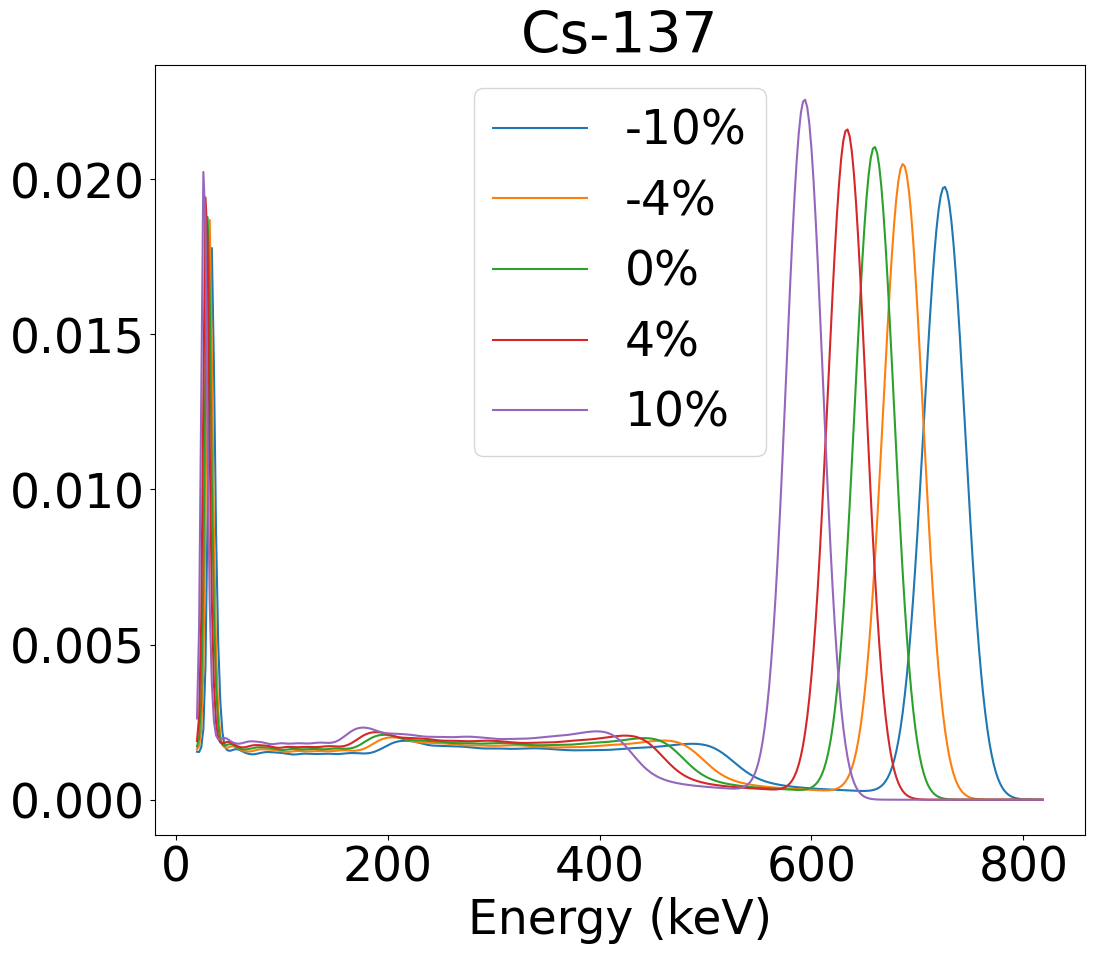

In [11]:
plt.figure(figsize=(12,10))
enr=(np.arange(1024)*2+20)
name=3

for i in [0,6,10,14,20]:
    plt.plot(enr[:max_channel_list[name]],spec_all_drift[i,0,:max_channel_list[name],name],label=str(int(list_alpha[i]*100))+'%')

plt.legend()
plt.xlabel('Energy (keV)')
plt.title(RN_NAME_plot[name])

# Define desired case (1,2 or 3)

In [12]:
variability=True # with variability
drift=False # with spectral drift
withI131=False # with I131 or not (for sepctral variability)
batch_size=512
FPR=0.01 # expected false positive rate


In [13]:
load_pretrained_model=True ##  set false  to train a new CNN model

In [14]:
max_channel_list=np.array([800,250,100,400,900,50,100,500,100])
# wo variability
if variability==False:
    mask=[0,1,2,3,4,5,6,7,8] # mask for radionuclides, use all radionuclides
    RN_NAME2=RN_NAME[mask]
    RN_NAME_plot2=RN_NAME_plot[mask]
    # scenario 1
    if drift==False:
        file_name='../data/Data_spectra_gamma_200000_wo_variability'
        path_checkpoint_quan='lightning_logs/CNN_regress_wo_var_drift.ckpt'
        path_res_unmmixing='../data/resultat_pomp'
    # scenario 3
    else:
        file_name='../data/Data_spectra_gamma_200000_wo_variability_drift'
        path_checkpoint_quan='lightning_logs/CNN_regress_drift.ckpt'
        mask=[0,1,2,3,4,5,6,7,8]
        path_res_unmmixing='../data/result_pomp_drift_all'

# scenario 2.2        
elif withI131==True:
    mask=[0,1,2,3,4,5,6,7]
    RN_NAME2=RN_NAME[mask]
    RN_NAME_plot2=RN_NAME_plot[mask]
    file_name='../data/Data_spectra_gamma_200000_variability_with_I131'
    path_checkpoint_quan='lightning_logs/CNN_regress_var_with_I131.ckpt'
    path_res_unmmixing='../data/resultat_moseva_with_I131'

# scenario 2.1
else:
    mask=[0,1,2,3,4,5,6,8]
    RN_NAME2=RN_NAME[mask]
    RN_NAME_plot2=RN_NAME_plot[mask]
    file_name='../Data/Data_spectra_gamma_200000_variability_wo_I131'
    path_checkpoint_quan='lightning_logs/CNN_regress_var_wo_I131.ckpt'
    path_res_unmmixing='../data/resultat_moseva_wo_I131'


max_channel_list=max_channel_list[mask]
    

## Create ML datasets

In [15]:
create_dataset=False # True: create new datasets

In [16]:
if create_dataset==True:
    ratio=np.array([0.64,0.16,0.2]) # train:val:test
    nb_sce=200000 # number of scenarios
    # min counting for radionuclide
    min_counting_radio=np.array([125,100,50,50,100,100,50,50,50,50])
    if (variability==False) and (drift==False): # known X
        list_sce=create_scenario_sota_gamma(np.arange(1,10),[200.0,100000.0],[0.1,0.9], min_counting_radio,
                        nb_sce=nb_sce)# [200,100000]: total counting:
        
        train_val_test=np.int_(ratio*len(list_sce))
        train_val_test=np.cumsum(train_val_test)
        data=np.split(list_sce,[train_val_test[0],train_val_test[1],train_val_test[2]])
    elif (variability==True):
        train_val_test=np.int_(ratio*nb_sce)
        # difference thickness of steel sphere for train, val, test
        list_thick=np.arange(96)
        np.random.seed(2)
        np.random.shuffle(list_thick)
        train_lamb,val_lamb,test_lamb=np.sort(list_thick[:62]),np.sort(list_thick[62:77]),np.sort(list_thick[77:])
        # create dataset for train, val, test
        data_train=create_scenario_variability(np.arange(1,9),[200.0,100000.0],[0.1,0.9], train_lamb,min_counting_radio,nb_sce=train_val_test[0])
        data_val=create_scenario_variability(np.arange(1,9),[200.0,100000.0],[0.1,0.9], val_lamb,min_counting_radio,nb_sce=train_val_test[1])
        data_test=create_scenario_variability(np.arange(1,9),[200.0,100000.0],[0.1,0.9], test_lamb,min_counting_radio,nb_sce=train_val_test[2])
        data=[data_train,data_val,data_test]
    else:
        alpha_list=np.arange(41)# alpha for spectral drift
        list_sce=create_scenario_sota_gamma(np.arange(1,9),[200.0,100000.0],[0.1,0.9], min_counting_radio,list_lamb=alpha_list,
                        nb_sce=nb_sce)# [200,100000]: total counting:
        train_val_test=np.int_(ratio*len(list_sce))
        train_val_test=np.cumsum(train_val_test)
        data=np.split(list_sce,[train_val_test[0],train_val_test[1],train_val_test[2]])

In [17]:
with open(file_name, "rb") as fp:   #Pickling
    data=pickle.load(fp)
data_train,data_val,data_test=data

# Quantification

In [18]:
import importlib
import CNN_classification_regression
importlib.reload(CNN_classification_regression)
from CNN_classification_regression import *

In [19]:
import data_ML
importlib.reload(data_ML)
from data_ML import *

In [20]:
if drift==True:
    data_load,data_set,data_test2,[val_dataloader2,test_dataloader2]=get_data_loader_multi(data,XBkg_drift,spec_all_drift[:,0:1,:,mask],variability=variability,batch_size=512,
                                                                                     drift=drift,classifi=False)
else:
    data_load,data_set,data_test2,[val_dataloader2,test_dataloader2]=get_data_loader_multi(data,XBkg,spec_list[:,:,mask],variability=variability,batch_size=512,
                                                                                     drift=drift,classifi=False)
train_dataloader,val_dataloader,test_dataloader=data_load
test_sce,test_y,test_X=data_test2

In [21]:

default_config = {
    "nbr_layer_cnn": 3,"nbr_layer_lin":2,
    "layer_size_1": 256,"layer_size_2": 128,"layer_size_default": 256,
    "kernel_1": 20, "kernel_2": 16, "kernel_default": 16,
     "max_pool_1":2,
        "max_pool_default":2, "stride_default":1, "dropout_default":0.5,
    "lr": 4.768552885534946e-05,
    "layer_fn_size_1" : 150,     "layer_fn_size_default" : 100,
    'loss_type': 1,
   
}

In [22]:

# default_config = {
#     "nbr_layer_cnn": 2,"nbr_layer_lin":2,
#     "layer_size_1": 64,"layer_size_2": 32,"layer_size_default": 256,
#     "kernel_1": 12, "kernel_2": 12, "kernel_default": 16,
#      "max_pool_1":1,
#         "max_pool_default":2, "stride_default":1, "dropout_default":0.1,
#     "lr": 4.768552885534946e-05,
#     "layer_fn_size_1" : 1024,     "layer_fn_size_default" : 128,
#     'loss_type': 1,}
#default_config=best_config

In [23]:
batch_size=512
input_shape=(batch_size, 1, spec_list.shape[1])
cnn_model=CNN_Regressfier(default_config,len(RN_NAME2)+1,input_shape)


In [24]:
import torchinfo 
from torchinfo  import summary
summary(cnn_model,input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
CNN_Regressfier                          [512, 9]                  --
├─Conv1d: 1-1                            [512, 256, 1005]          5,376
├─MaxPool1d: 1-2                         [512, 256, 502]           --
├─BatchNorm1d: 1-3                       [512, 256, 502]           512
├─Conv1d: 1-4                            [512, 128, 487]           524,416
├─MaxPool1d: 1-5                         [512, 128, 243]           --
├─BatchNorm1d: 1-6                       [512, 128, 243]           256
├─Conv1d: 1-7                            [512, 256, 228]           524,544
├─MaxPool1d: 1-8                         [512, 256, 114]           --
├─BatchNorm1d: 1-9                       [512, 256, 114]           512
├─Flatten: 1-10                          [512, 29184]              --
├─Linear: 1-11                           [512, 150]                4,377,750
├─Dropout: 1-12                          [512, 150]           

In [25]:
load_pretrained_model=True ##  set false  to train a new CNN model
max_epochs=150
early_stop=5

In [26]:
if load_pretrained_model==False:
    t1=time.time()
    filename='CNN_regress_drift'# can be modified
    path_log='./lightning_logs'
    checkpoint_callback = ModelCheckpoint(dirpath=path_log,filename=filename)
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator="auto",
        devices="auto",
        callbacks=[EarlyStopping('val_loss', patience=early_stop),checkpoint_callback],# early stopping, can be modified
        enable_progress_bar=True,
        default_root_dir=path_log
    )
    trainer.fit(cnn_model, train_dataloader, val_dataloader)
    test_out=trainer.test(cnn_model,test_dataloader)
    print('time: ',time.time()-t1)

In [27]:
# load tensorboard to visualise
if load_pretrained_model==False:
    %load_ext tensorboard
    %tensorboard --logdir lightning_logs/



# Fine tuning

In [28]:
fine_tuning=False

In [29]:
# The maximum training epochs
num_epochs = 20

# Number of sampls from parameter space
num_samples = 30

In [30]:
if fine_tuning==True:
    # change access path to absolute path (for ray) 
    #os.environ['PYTHONPATH'] = 'your absolute path'
    #import CNN_classification_regression
    from ray import tune
    from ray.tune.schedulers import ASHAScheduler
    from ray.train.torch import TorchConfig
    from ray.train.torch import TorchTrainer
    import ray
    from ray.train.lightning import (RayDDPStrategy,RayLightningEnvironment, RayTrainReportCallback,prepare_trainer,)
    def tune_mnist_asha(search_space,ray_trainer,num_epochs,num_samples=10):
        scheduler = ASHAScheduler(max_t=num_epochs, grace_period=1, reduction_factor=2)
        tuner = tune.Tuner(ray_trainer,param_space={"train_loop_config": search_space},
            tune_config=tune.TuneConfig(metric="val_loss",mode="min",num_samples=num_samples,scheduler=scheduler,),)
        #use accuracy of validation as a metric to choose the best
        # change mode into min for regression
        return tuner.fit()
    def train_func(config):
        model=CNN_Regressfier(config,len(RN_NAME2)+1,input_shape)
        trainer = pl.Trainer(devices="auto",accelerator="auto",strategy=RayDDPStrategy(),
            callbacks=[RayTrainReportCallback()],plugins=[RayLightningEnvironment()],enable_progress_bar=False)
        trainer = prepare_trainer(trainer)
        trainer.fit(model, train_dataloader, val_dataloader) # change data

    search_space = {
    "nbr_layer_cnn":tune.choice([3,4]),  "nbr_layer_lin":tune.choice([1,2,3]),
    "layer_size_1": tune.choice([128,200,256]),"layer_size_2": tune.choice([200,256]),"layer_size_default": tune.choice([256 ]),
    "kernel_1":  tune.choice([16,20]), "kernel_2":  tune.choice([16,20]), "kernel_default": tune.choice([16]),
     "max_pool_1": tune.choice([2,3]),   "max_pool_default":2, "stride_default":1, "dropout_default":0.5,
    "lr": tune.loguniform(3e-4, 1e-5),
    "layer_fn_size_1" : tune.choice([100,150,200,250]),"layer_fn_size_default" : tune.choice([100]),
        'loss_type':  tune.choice([1])
   }
    
    
    from ray.train import RunConfig, ScalingConfig, CheckpointConfig
    # change the number of CPU, GPU
    scaling_config = ScalingConfig(num_workers=1, use_gpu=True, resources_per_worker={"CPU": 10, "GPU": 1})
    ### only for window
    #torch_config = TorchConfig(backend="gloo")
    ######
    run_config = RunConfig(checkpoint_config=CheckpointConfig(num_to_keep=2,checkpoint_score_attribute="val_loss",checkpoint_score_order="min"))
    # Define a TorchTrainer without hyper-parameters for Tuner
    ray_trainer = TorchTrainer(train_func,torch_config=torch_config,scaling_config=scaling_config,run_config=run_config,)
    ################# fine tune hyperparameters
    results = tune_mnist_asha(search_space,ray_trainer,num_epochs,num_samples=num_samples)
    ##############
    best_config=results.get_best_result(metric="val_loss", mode="min").config['train_loop_config']

# Results

## Use quantification result to identify

## CNN

In [31]:
# checkpoint = torch.load(path_checkpoint_quan)
# best_config=checkpoint["hyper_parameters"]['config']
# best_config

In [32]:
#load pre-trained model
model = CNN_Regressfier.load_from_checkpoint(path_checkpoint_quan)
# disable randomness, dropout, etc...
model.eval()


CNN_Regressfier(
  (loss_fn): CrossEntropyLoss()
  (train_accuracy): CrossEntropyLoss()
  (val_accuracy): CrossEntropyLoss()
  (conv1): Conv1d(1, 200, kernel_size=(16,), stride=(1,))
  (pool1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (batch1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(200, 256, kernel_size=(20,), stride=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batch2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 256, kernel_size=(16,), stride=(1,))
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batch3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(256, 256, kernel_size=(16,), stride=(1,))
  (pool4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batch4): Ba

In [33]:
trainer =  pl.Trainer(accelerator="auto",devices="auto",)
y_pred_val=trainer.predict(model, dataloaders=val_dataloader2)
if model.loss_type!=0: # cross-entropy loss
    y_pred_val=[F.softmax(y_pred_val[i],dim=1).detach().numpy() for i in range(len(y_pred_val))]
else: # MSE
    y_pred_val=[(y_pred_val[i]).detach().numpy() for i in range(len(y_pred_val))]
y_pred_val=np.concatenate(y_pred_val,0)
if (variability==False) and (drift==False):
    y_true_val=data_val[:,0:]/np.sum(data_val[:,0:],1).reshape(-1,1)
else:
    y_true_val=data_val[:,0:-1]/np.sum(data_val[:,0:-1],1).reshape(-1,1)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A1000 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\DP272459\Anaconda3\envs\pytorch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████| 63/63 [00:06<00:00, 10.18it/s]


### Choose threshold using validation dataset

In [34]:
threshold=np.linspace(0.001,0.101,51)
res_threshold=[]
y_true=y_true_val>0
for j in range(len(threshold)):
    y_pred=1*(y_pred_val>threshold[j])
    false_cnn,false_pos_cnn,false_nev_cnn=[],[],[]
    n=len(y_true_val)
    for i in range(n):
        if not (y_pred[i]==y_true[i]).all():
            false_cnn+=[i]
            list_radio_pres=np.arange(len(RN_NAME2)+1)[y_true[i]==1]   
            tmp=np.arange(len(RN_NAME2)+1)[y_pred[i]==1]#list radio present estimated
            if all(item in tmp for item in list_radio_pres):
                false_pos_cnn+=[i]
            elif all(item in list_radio_pres for item in tmp):
                false_nev_cnn+=[i]
            else:
                false_nev_cnn+=[i]
                false_pos_cnn+=[i]
    cf_matrix = multilabel_confusion_matrix(y_true, y_pred)
    all_cf=np.sum(cf_matrix,0)
    res_threshold+=[[len(false_cnn)/n,len(false_pos_cnn)/n,len(false_nev_cnn)/n,(all_cf[0,0]+all_cf[1,1])/np.sum(all_cf)]]
res_threshold=np.array(res_threshold)

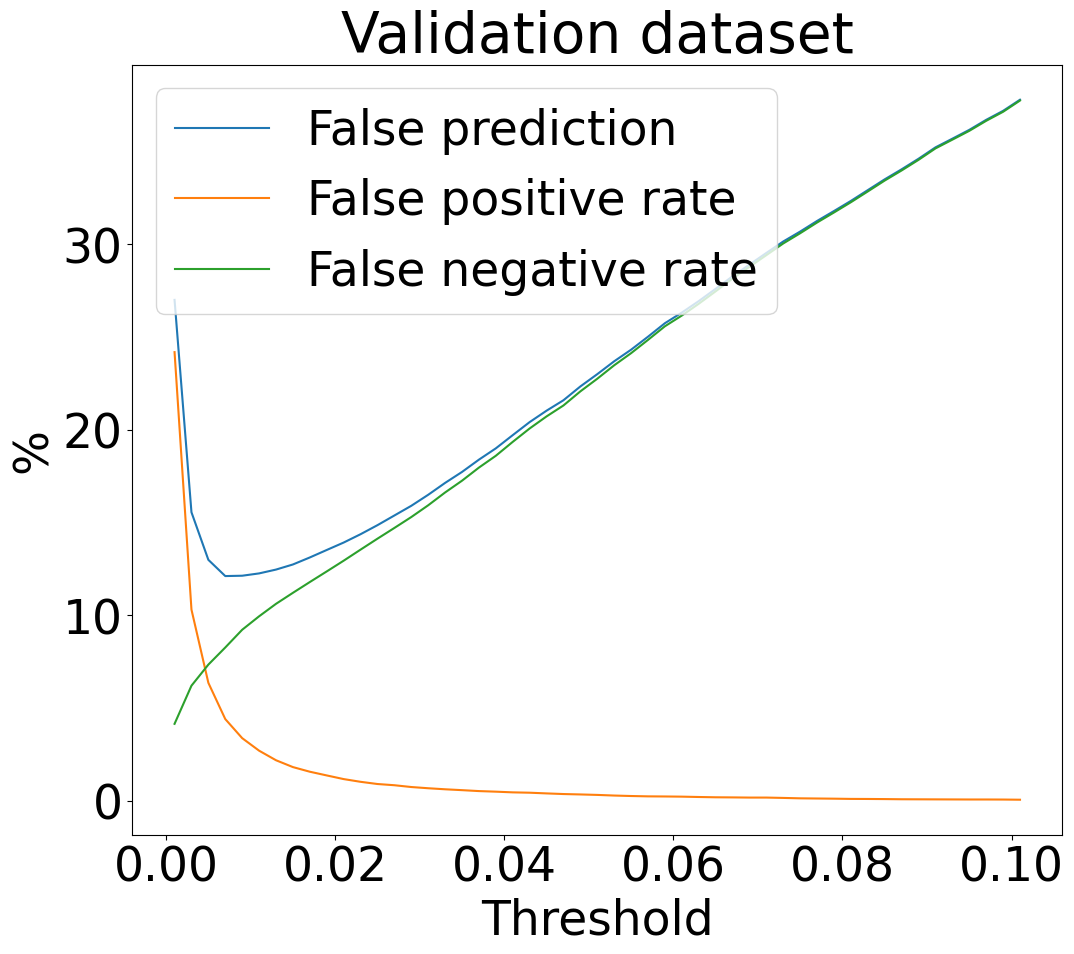

In [35]:
plt.figure(figsize=(12,10))
plt.plot(threshold,res_threshold[:,0]*100,label='False prediction')
plt.plot(threshold,res_threshold[:,1]*100,label='False positive rate')
plt.plot(threshold,res_threshold[:,2]*100,label='False negative rate')
#plt.plot(threshold,res_threshold[:,3]*100,label='Average accuracy')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('%')
plt.title('Validation dataset')
name_fig= PATH+ 'threshold_accuracy_cnn'+name_fig_sup
#plt.savefig(name_fig)

In [36]:
# choose threshold to give a FPR close to expected value
ind=np.argmin((res_threshold[:,1]-FPR)**2)
threshold_FPR=threshold[ind]


In [37]:
# different threshold for each radionuclide
# give the best accuracy for each radionuclide
threshold=np.linspace(0.001,0.101,51)
res_threshold_radio=[]
y_true=y_true_val>0
for j in range(len(threshold)):
    y_pred=1*(y_pred_val>=threshold[j])
    cf_matrix = multilabel_confusion_matrix(y_true, y_pred)
    res_threshold_radio+=[[cf_matrix[:,0,1],cf_matrix[:,1,0],cf_matrix[:,0,1]+cf_matrix[:,1,0]]]
res_threshold_radio=np.array(res_threshold_radio)
res_threshold_radio=res_threshold_radio/len(y_true)
# index give the best accuracy for each radionuclide
index_best_radio=np.argmin(res_threshold_radio[:,2,:],0)


### Test dataset

In [38]:
y_pred_cnn_raw=trainer.predict(model, dataloaders=test_dataloader2)
if model.loss_type!=0: # cross-entropy loss
    y_pred_cnn_raw=[F.softmax(y_pred_cnn_raw[i],dim=1).detach().numpy() for i in range(len(y_pred_cnn_raw))]
else:
    y_pred_cnn_raw=[(y_pred_cnn_raw[i]).detach().numpy() for i in range(len(y_pred_cnn_raw))]

y_pred_cnn_raw=np.concatenate(y_pred_cnn_raw,0)
if (variability==False) and (drift==False):
    y_true_test=data_test[:,0:]/np.sum(data_test[:,0:],1).reshape(-1,1)
else:
    y_true_test=data_test[:,0:-1]/np.sum(data_test[:,0:-1],1).reshape(-1,1)


You are using a CUDA device ('NVIDIA RTX A1000 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\DP272459\Anaconda3\envs\pytorch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████| 79/79 [00:07<00:00, 10.15it/s]


In [39]:
# result of CNN which gives a FPR close to expectd value
y_pred_cnn=1*(y_pred_cnn_raw>=threshold_FPR)
# result of CNN which gives the best accuracy
threshold_radio=(threshold[index_best_radio])*np.ones(len(y_true_test)).reshape(-1,1)
y_pred_cnn_best=1*(y_pred_cnn_raw>=threshold_radio)
# choose the case for which you want to show the result 
data_tmp=y_pred_cnn
#data_tmp=y_pred_cnn_best


In [40]:
print('Use mixing weight for identification')
y_true=y_true_test>0
data_tmp=data_tmp>0

cf_matrix_cnn = multilabel_confusion_matrix(y_true, data_tmp)
all_cf_cnn=np.sum(cf_matrix_cnn,0)
print(f'Accuracy: {(all_cf_cnn[0,0]+all_cf_cnn[1,1])/np.sum(all_cf_cnn)*100:.2f}')

acc_test=np.all(data_tmp==y_true,1)*1
print(f'PPR:  {np.sum(acc_test)/len(acc_test)*100:.2f}')

false_cnn=[]
false_pos_cnn=[]
false_nev_cnn=[]

#y_pred=(res_unmixing[3][:,h,1:]>0)*1

for i in range(len(y_true)):
    if not (data_tmp[i]==y_true[i]).all():
        false_cnn+=[i]
        list_radio_pres=np.arange(len(RN_NAME2)+1)[y_true[i]==1]   
               
        tmp=np.arange(len(RN_NAME2)+1)[data_tmp[i]==1]#list radio present estimated
        if all(item in tmp for item in list_radio_pres):
            false_pos_cnn+=[i]
        elif all(item in list_radio_pres for item in tmp):
            false_nev_cnn+=[i]
        else:
            false_nev_cnn+=[i]
            false_pos_cnn+=[i]
print(f'False prediction: {len(false_cnn)/len(test_sce)*100:.2f}')
print(f'False positive cnn: {len(false_pos_cnn)/len(test_sce)*100:.2f}')
print(f'False negative cnn: {len(false_nev_cnn)/len(test_sce)*100:.2f}')



Use mixing weight for identification
Accuracy: 98.29
PPR:  86.37
False prediction: 13.63
False positive cnn: 0.91
False negative cnn: 12.88


# Result of statistical approach

In [41]:
with open(path_res_unmmixing, "rb") as fp:   #Pickling
    res_unmixing=pickle.load(fp)

In [42]:
h=2
y_pred_unmixing=(res_unmixing[-1][:,h,1:]>0)*1
y_true=y_true_test[:,1:]>0
tmp2=res_unmixing[-1][:,h,1:].copy()

### at least 1% of all radio counting (without Bkg) -> remove false positive of IAE
if (variability==True) or (drift==True):
    threshold2=0.01
    counting_threshold=np.sum(tmp2[:,1:len(RN_NAME2)],1).reshape(-1,1).dot(np.ones((1,len(RN_NAME2))))
    # < alpha% of all counting
    tmp2*= (tmp2>counting_threshold*threshold2)
### > min counting
if drift==True:
    min_counting_radio=np.array([100,50,50,100,100,50,50,50,50])
    min_counting_radio=min_counting_radio[mask]
    min_counting_radio=min_counting_radio-np.sqrt(min_counting_radio)*3
    counting_threshold=np.dot(np.ones((len(y_pred_unmixing),1)),min_counting_radio.reshape((1,-1)))
    tmp2*=(tmp2>=counting_threshold)
    
y_pred_unmixing=(tmp2[:,:]>0)*1



print('Spectral unmixing')
cf_matrix_unmixing=multilabel_confusion_matrix(y_true,y_pred_unmixing)
all_cf_unmixing=np.sum(cf_matrix_unmixing,0)
print(f'Accuracy: {(all_cf_unmixing[0,0]+all_cf_unmixing[1,1])/np.sum(all_cf_unmixing)*100:.2f}')
acc_test=np.all(y_pred_unmixing==y_true,1)*1
print(f'PPR:  {np.sum(acc_test)/len(acc_test)*100:.2f}')

false_unmixing=[]
false_pos_unmixing=[]
false_nev_unmixing=[]


for i in range(len(test_sce)):
    if not (y_pred_unmixing[i]==y_true[i]).all():
        false_unmixing+=[i]
        list_radio_pres=np.arange(len(RN_NAME2))[y_true[i]==1]   
               
        tmp=np.arange(len(RN_NAME2))[y_pred_unmixing[i]==1]#list radio present estimated
        if all(item in tmp for item in list_radio_pres):
            false_pos_unmixing+=[i]
        elif all(item in list_radio_pres for item in tmp):
            false_nev_unmixing+=[i]
        else:
            false_nev_unmixing+=[i]
            false_pos_unmixing+=[i]
            
print(f'False unmixing: {len(false_unmixing)/len(test_sce)*100:.2f}')
print(f'False positive unmixing: {len(false_pos_unmixing)/len(test_sce)*100:.2f}')
print(f'False negative unmixing: {len(false_nev_unmixing)/len(test_sce)*100:.2f}')


Spectral unmixing
Accuracy: 99.12
PPR:  93.55
False unmixing: 6.45
False positive unmixing: 0.89
False negative unmixing: 5.70


# Quantification results

###  Choose the output of CNN regression model

In [43]:
res_cnn=[y_pred_cnn_raw,y_pred_cnn_raw*(y_pred_cnn_raw>=threshold_FPR),y_pred_cnn_raw*(y_pred_cnn_raw>=threshold_radio)]
# [raw output, give the FPR close to expected value, best accuracy]
data_cnn_tmp=res_cnn[0]# can be modified # 0: raw output of CNN
#data_cnn_tmp=data_cnn_tmp/np.sum(data_cnn_tmp,1).reshape(-1,1) # normalized

### Total counting

In [44]:
# total counting (sum(a)) for the simulated spectrum (with poisson noise) 
# the result of statistical spectral unmixing: POMP,MoSeVa based on NNPU algorithm to estimate a
# it has a property: estimated sum(a) = sum(a) for simulated spectrum
# to recover sum(a) for poisson simulated spectrum: 
est_total_counting=np.sum(res_unmixing[-1][:,h,:],1)
# total counting (sum(a)) for the theoretical spectrum (without poisson noise) 
total_counting=np.sum(test_sce,1)


### MSE on mixing weights

In [45]:
y_pred_unmixing=res_unmixing[-1][:,h,:]/np.sum(res_unmixing[-1][:,h,:],1).reshape(-1,1)
print('MSE CNN : ', np.round(np.mean((data_cnn_tmp-y_true_test)**2),6))
print('MSE Unmixing: ',np.round(np.mean((y_pred_unmixing-y_true_test)**2),6))

MSE CNN :  0.000295
MSE Unmixing:  0.000118


### Relative absolute error

In [46]:
print('Relative absolute error of counting (%)')
re_cnn=[]
list_rel_err=[]
list_a_est=[data_cnn_tmp,y_pred_unmixing]
for j in range(len(list_a_est)):
    rel_err=[]
    data_rel=list_a_est[j]
    for i in range(n):
        radio=y_true_test[i]>0
        rel_err+=[(np.abs(data_rel[i]*est_total_counting[i]-y_true_test[i]*total_counting[i])[radio]/
                  (y_true_test[i]*total_counting[i])[radio]).reshape(-1,1)]
    rel_err=np.concatenate(rel_err)
    list_rel_err+=[rel_err]
list_rel_err=np.array(list_rel_err)
print('Rel err CNN : ', np.round(np.mean(list_rel_err[0])*100,3))
print('Rel err Unmixing: ', np.round(np.mean(list_rel_err[1])*100,3))


Relative absolute error of counting (%)
Rel err CNN :  13.212
Rel err Unmixing:  7.463


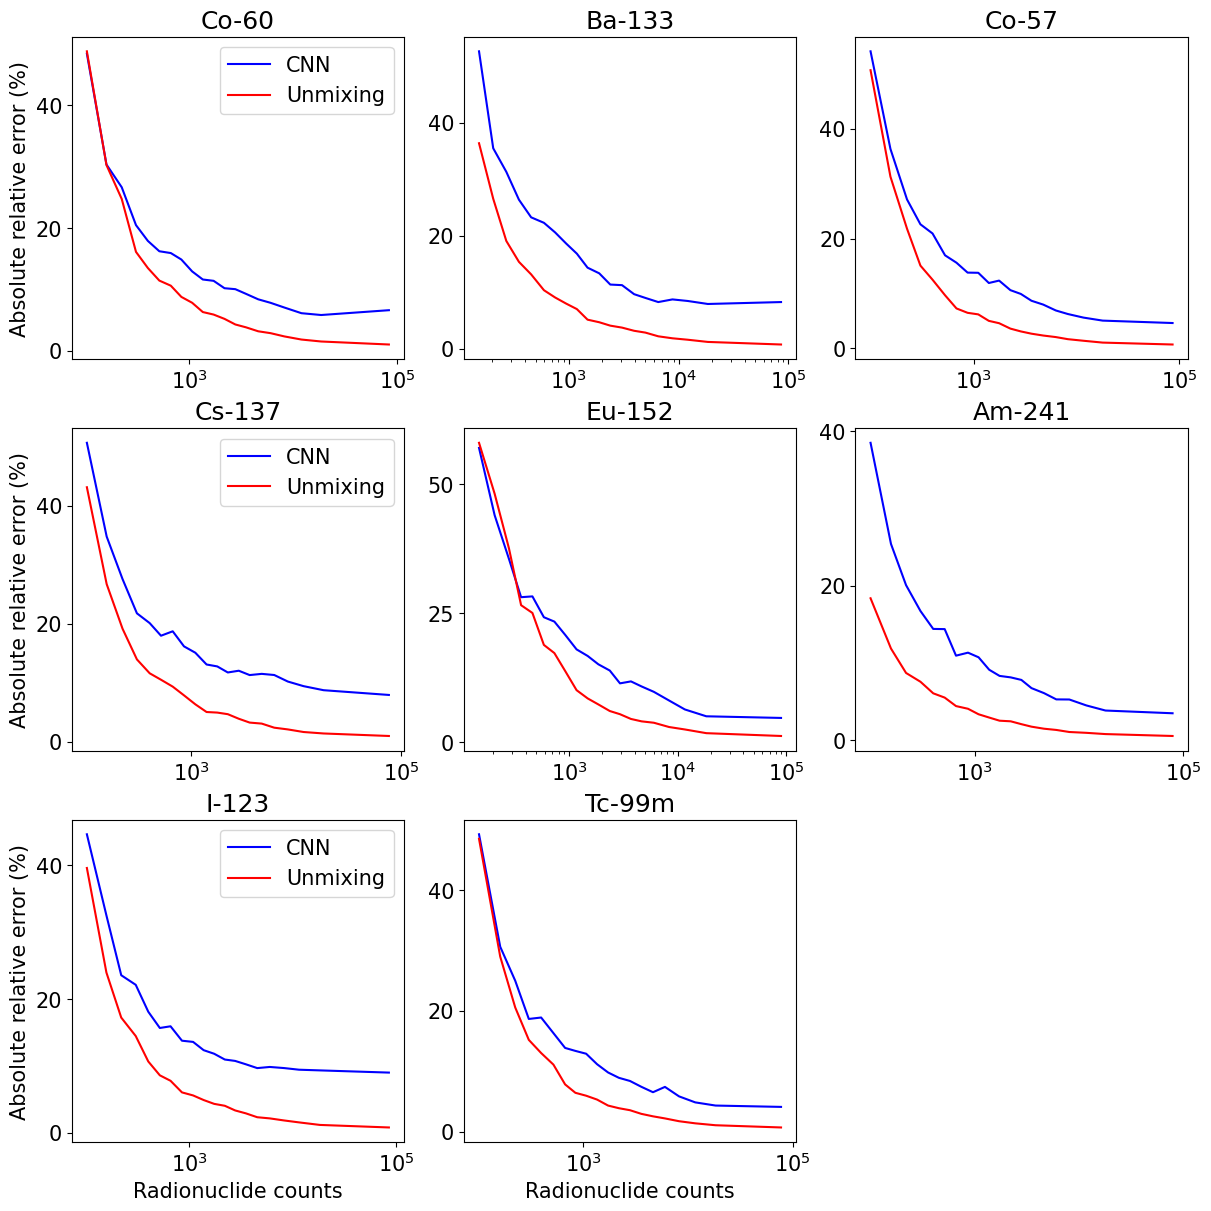

In [47]:
list_res=[data_cnn_tmp,y_pred_unmixing]
labels_name=['CNN','Unmixing']

plt.rcParams.update({'font.size': 15})
nbr_plot=[0,1]

fig, axs = plt.subplots(3, 3, figsize=(12, 12),layout="constrained")
for i in range(len(RN_NAME2)):
    ax=axs.flat[i]
    index=test_sce[:,i+1]>0
    count_radio=test_sce[index,i+1]
    sort_list=np.sort(count_radio)
    sort_index=np.argsort(count_radio)
    
    res_cnn_sort=[list_res[k][index][sort_index,i+1] for k in range(len(list_res))]
    res_cnn_sort=np.array(res_cnn_sort)
    a_sort=test_y[index][sort_index,i+1]
    a_sort=a_sort*total_counting[index][sort_index]
    res_err_sort=(np.abs(res_cnn_sort*est_total_counting[index][sort_index]-a_sort)/a_sort) # relative error
    #res_cnn_sort=-20*np.log10(np.abs(res_cnn_sort-a_sort)/a_sort)# NMSE
    
    bins=sort_list[np.arange(20)*np.int_(len(sort_list)/20)]
    bins=np.append(bins,np.max(sort_list))
    hist1=np.histogram(count_radio,bins=bins)
    nbr_by_bins=np.cumsum(hist1[0])
    nbr_by_bins=np.append([0],nbr_by_bins)
    res_err_sort2=[]
    for k in range(len(nbr_by_bins)-1):
        res_err_sort2+=[np.mean(res_err_sort[:,nbr_by_bins[k]:nbr_by_bins[k+1]],(1))]
    res_err_sort2=np.array(res_err_sort2)
    
    for j in range(len(labels_name)):
        ax.plot(hist1[1][1:],res_err_sort2[:,j]*100,label=labels_name[j],color=vcol[j])

    ax.set_xscale('log')
    if i>=6:
        ax.set_xlabel('Radionuclide counts')
    if i%3==0:
        ax.set_ylabel('Absolute relative error (%)')
        ax.legend()
    ax.set_title(RN_NAME_plot2[i])
if i==7:
    ax=axs.flat[i+1]
    ax.set_visible(False)
plt.rcParams.update({'font.size': 34})
name_fig= PATH+ 'false_neg_rate_all2'+name_fig_sup
#plt.savefig(name_fig)

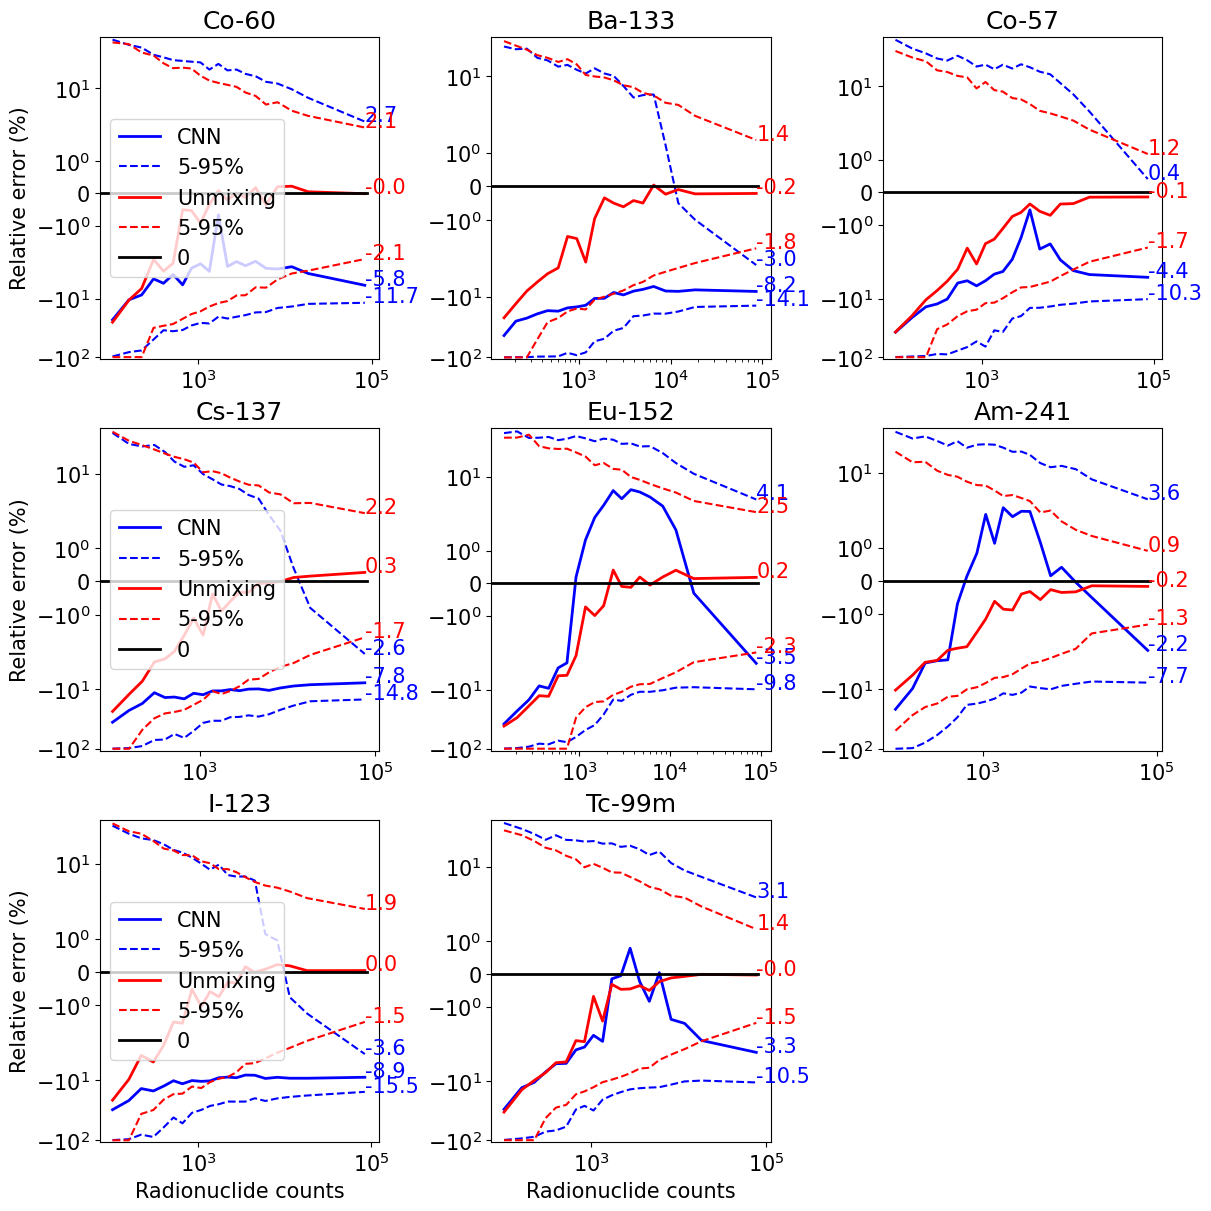

In [48]:


plt.rcParams.update({'font.size': 15})
font_size=15
fig, axs = plt.subplots(3, 3, figsize=(12, 12),layout="constrained")
for i in range(len(RN_NAME2)):
    ax=axs.flat[i]
    index=test_sce[:,i+1]>0
    count_radio=test_sce[index,i+1]
    sort_list=np.sort(count_radio)
    sort_index=np.argsort(count_radio)
    
    res_cnn_sort=[list_res[k][index][sort_index,i+1] for k in range(len(list_res))]
    res_cnn_sort=np.array(res_cnn_sort)
    a_sort=test_y[index][sort_index,i+1]
    a_sort=a_sort*total_counting[index][sort_index]
    res_err_sort=((res_cnn_sort*est_total_counting[index][sort_index]-a_sort)/a_sort) # relative error
    #res_cnn_sort=-20*np.log10(np.abs(res_cnn_sort-a_sort)/a_sort)# NMSE
    
    bins=sort_list[np.arange(20)*np.int_(len(sort_list)/20)]
    bins=np.append(bins,np.max(sort_list))
    hist1=np.histogram(count_radio,bins=bins)
    nbr_by_bins=np.cumsum(hist1[0])
    nbr_by_bins=np.append([0],nbr_by_bins)
    res_err_sort2=[]
    res_err_sort2_5=[]
    res_err_sort2_95=[]

    for k in range(len(nbr_by_bins)-1):
        res_err_sort2+=[np.mean(res_err_sort[:,nbr_by_bins[k]:nbr_by_bins[k+1]],(1))]
        res_err_sort2_5+=[np.quantile(res_err_sort[:,nbr_by_bins[k]:nbr_by_bins[k+1]],0.05,(1))]
        res_err_sort2_95+=[np.quantile(res_err_sort[:,nbr_by_bins[k]:nbr_by_bins[k+1]],0.95,(1))]

    res_err_sort2=np.array(res_err_sort2)
    res_err_sort2_5=np.array(res_err_sort2_5)
    res_err_sort2_95=np.array(res_err_sort2_95)

    for j in range(len(labels_name)):
        ax.plot(hist1[1][1:],res_err_sort2[:,j]*100,label=labels_name[j],lw=2,color=vcol[j])
        ax.plot(hist1[1][1:],res_err_sort2_5[:,j]*100,'--',label='5-95%',color=vcol[j])
        ax.plot(hist1[1][1:],res_err_sort2_95[:,j]*100,'--',color=vcol[j])
        ax.annotate(np.round(res_err_sort2[-1,j]*100,1), (hist1[1][-1], res_err_sort2[-1,j]*100),color=vcol[j],fontsize=font_size)
        ax.annotate(np.round(res_err_sort2_5[-1,j]*100,1), (hist1[1][-1], res_err_sort2_5[-1,j]*100),color=vcol[j],fontsize=font_size)
        ax.annotate(np.round(res_err_sort2_95[-1,j]*100,1), (hist1[1][-1], res_err_sort2_95[-1,j]*100),color=vcol[j],fontsize=font_size)

    xlims=ax.get_xlim()
    ax.plot(np.linspace(xlims[0],xlims[1],100),np.array(0)*np.ones(100),lw=2,color='black',label='0')
    ax.set_xscale('log')
    if i>=6:
        ax.set_xlabel('Radionuclide counts')
    if i%3==0:
        ax.set_ylabel('Relative error (%)')
        ax.legend()
    ax.set_title(RN_NAME_plot2[i])
    ax.set_yscale('symlog')
if i==7:
    ax=axs.flat[i+1]
    ax.set_visible(False)
plt.rcParams.update({'font.size': 34})
name_fig= PATH+ 'rel_err'+name_fig_sup
#plt.savefig(name_fig)